C:\Users\swara\AppData\Local\Temp\ipykernel_6800\3138518637.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


VaR and CVaR for the Portfolio:
  Confidence Level         VaR        CVaR
0           90.00%  ₹10,802.61  ₹16,955.80
1           95.00%  ₹15,094.93  ₹21,115.91
2           99.00%  ₹26,690.28  ₹30,380.53

VaR Breach Analysis:
90% VaR: 124 breaches (10.02% of days)
95% VaR: 62 breaches (5.01% of days)
99% VaR: 13 breaches (1.05% of days)


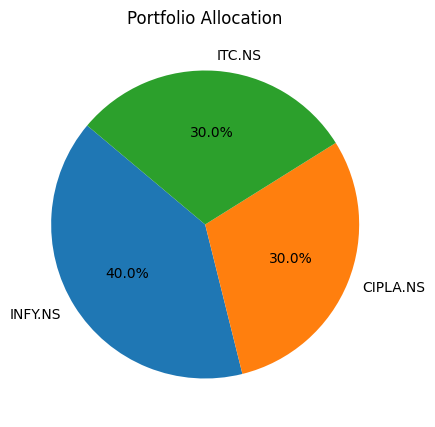

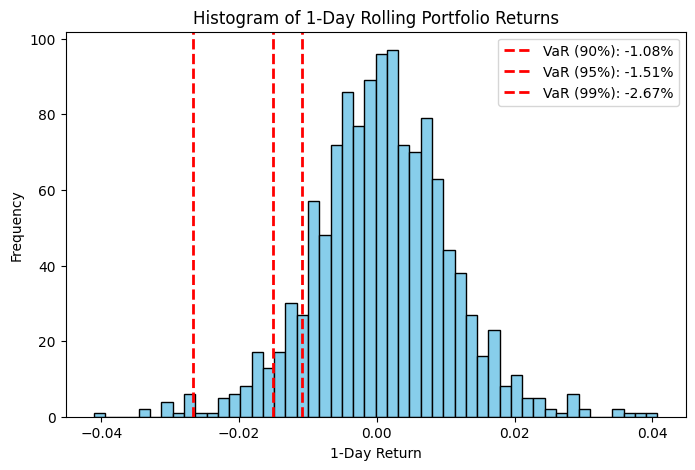

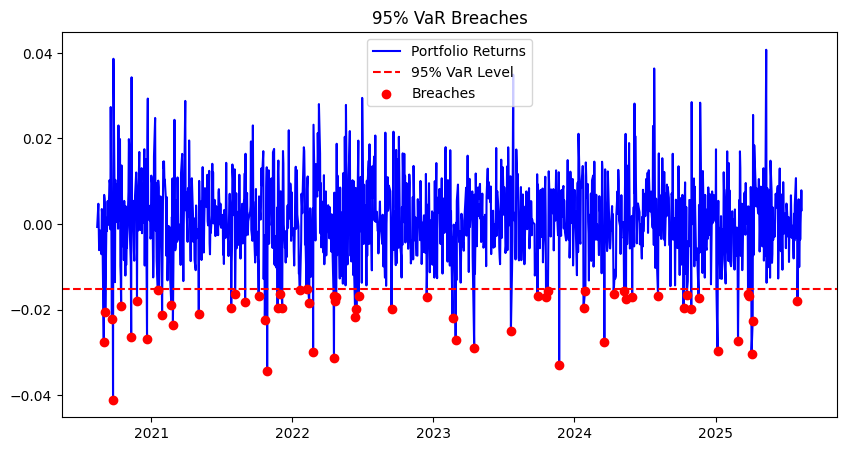

In [3]:
# ==========================
# Historical VaR Model
# ==========================

import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

# ------------------- CONFIGURATION -------------------
YEARS = 5
TICKERS = ['INFY.NS', 'CIPLA.NS', 'ITC.NS']
WEIGHTS = [0.4, 0.3, 0.3]  # Customizable portfolio weights
PORTFOLIO_VALUE = 1_000_000
CONFIDENCE_LEVELS = [0.90, 0.95, 0.99]
DAYS = 1
PLOT_RESULTS = True
# ------------------------------------------------------

def fetch_price_data(tickers, years):
    """Fetch adjusted closing prices for given tickers."""
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=365 * years)
    prices = yf.download(tickers, start=start_date, end=end_date)['Close']
    prices = prices.ffill().dropna()
    return pd.DataFrame(prices)

def calculate_portfolio_returns(prices, weights):
    """Calculate daily portfolio returns."""
    weights = np.array(weights)
    weights = weights / np.sum(weights)  # Normalize
    returns = prices.pct_change().dropna()
    return returns.dot(weights)

def calculate_var_cvar(portfolio_returns, confidence_levels, portfolio_value, days=1):
    """Calculate VaR and CVaR for given confidence levels."""
    range_returns = portfolio_returns.rolling(window=days).sum().dropna()
    results = []
    
    for cl in confidence_levels:
        var_cutoff = np.percentile(range_returns, (1 - cl) * 100)
        cvar = range_returns[range_returns <= var_cutoff].mean()
        results.append({
            "Confidence Level": f"{cl*100:.2f}%",
            "VaR": f"₹{-var_cutoff * portfolio_value:,.2f}",
            "CVaR": f"₹{-cvar * portfolio_value:,.2f}"
        })
    
    return pd.DataFrame(results), range_returns

def backtest_var_breaches(range_returns, cl):
    """Check how often actual losses exceeded VaR."""
    var_cutoff = np.percentile(range_returns, (1 - cl) * 100)
    breaches = range_returns < var_cutoff
    breach_count = breaches.sum()
    total_obs = len(range_returns)
    return breach_count, breach_count / total_obs

def plot_distribution(range_returns, confidence_levels, days):
    """Plot return distribution with VaR cutoffs."""
    plt.figure(figsize=(8, 5))
    plt.hist(range_returns, bins=50, color='skyblue', edgecolor='black')

    for cl in confidence_levels:
        cutoff = np.percentile(range_returns, (1 - cl) * 100)
        plt.axvline(cutoff, color='red', linestyle='dashed', linewidth=2,
                    label=f'VaR ({int(cl * 100)}%): {cutoff:.2%}')

    plt.title(f'Histogram of {days}-Day Rolling Portfolio Returns')
    plt.xlabel(f'{days}-Day Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_portfolio_weights(tickers, weights):
    """Pie chart of portfolio weights."""
    plt.figure(figsize=(5, 5))
    plt.pie(weights, labels=tickers, autopct='%1.1f%%', startangle=140)
    plt.title("Portfolio Allocation")
    plt.show()

def plot_var_breaches(portfolio_returns, cl, days):
    """Time series plot of portfolio returns with VaR breaches marked."""
    var_cutoff = np.percentile(portfolio_returns.rolling(window=days).sum().dropna(), (1 - cl) * 100)
    breaches = portfolio_returns < var_cutoff

    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_returns.index, portfolio_returns, label="Portfolio Returns", color="blue")
    plt.axhline(var_cutoff, color="red", linestyle="--", label=f"{int(cl*100)}% VaR Level")
    plt.scatter(portfolio_returns.index[breaches], portfolio_returns[breaches], color="red", label="Breaches", zorder=5)
    plt.title(f"{int(cl*100)}% VaR Breaches")
    plt.legend()
    plt.show()

# ------------------- MAIN SCRIPT -------------------
if __name__ == "__main__":
    prices = fetch_price_data(TICKERS, YEARS)
    portfolio_returns = calculate_portfolio_returns(prices, WEIGHTS)

    var_cvar_df, range_returns = calculate_var_cvar(portfolio_returns, CONFIDENCE_LEVELS, PORTFOLIO_VALUE, DAYS)

    print("\nVaR and CVaR for the Portfolio:")
    print(var_cvar_df)

    # Backtesting results
    print("\nVaR Breach Analysis:")
    for cl in CONFIDENCE_LEVELS:
        breaches, breach_rate = backtest_var_breaches(range_returns, cl)
        print(f"{int(cl*100)}% VaR: {breaches} breaches ({breach_rate:.2%} of days)")

    if PLOT_RESULTS:
        plot_portfolio_weights(TICKERS, WEIGHTS)
        plot_distribution(range_returns, CONFIDENCE_LEVELS, DAYS)
        plot_var_breaches(portfolio_returns, 0.95, DAYS)
